#### Logistic regression, example 1 - Social Network Ads, data, version 2

<b>We'll attempt some optimizations on this dataset</b>

Also: how to use scikit-learn's Pipelines for easier scaling etc.

In [25]:
import numpy as np

# LOCK DOWN THE RANDOM SEED SO WE CAN REPRODUCE THE SAME RESULTS EVERY TIME
# randomly guessed this one, probably a better idea to use for-loops to get the optimal value like this
np.random.seed(19991)

import pandas as pd

In [26]:
# load data 
df = pd.read_csv("Social_Network_Ads.csv")

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# IMPORT THE PIPELINES FROM SCIKIT-LEARN USED IN THIS EXAMPLE
# import pipeline and different optimization methods
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

In [28]:
df.tail()

,User ID,Gender,Age,EstimatedSalary,Purchased
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0
399,15594041,Female,49,36000,1


In [29]:
# since every row of data based on User ID is unique
# we can assume, that we don't have duplicates
# we probably have some duplicates after we remove the User ID
# so it's good to keep in mind (we can skip the duplicate removal because of this)
df['User ID'].value_counts()

User ID
15624510    1
15810944    1
15668575    1
15603246    1
15804002    1
           ..
15691863    1
15706071    1
15654296    1
15755018    1
15594041    1
Name: count, Length: 400, dtype: int64

In [30]:
# before removing the User ID, we don't have duplicates
# THIS IMPLIES, EVERY ROW IN THIS DATA IS UNIQUE, NO DUPLICATES PRESENT
df.duplicated().sum()

np.int64(0)

In [31]:
# drop the User ID since it's more like a background variable
# from some kind of data system etc. no statistical meaning
df = df.drop("User ID", axis=1)

In [32]:
# this is a rare case, we now have 20 duplicates, so there are
# different people with same characteristics in the data, but they
# are actually different people based on the User ID
# this is very hard to notice, and often doesn't affect the model that much
df.duplicated().sum()

np.int64(20)

In [33]:
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


<Axes: >

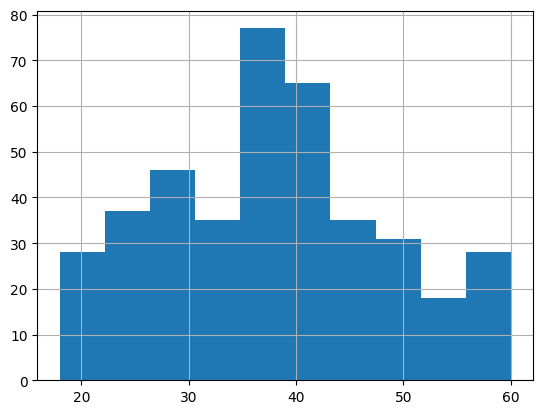

In [34]:
df['Age'].hist()

<Axes: >

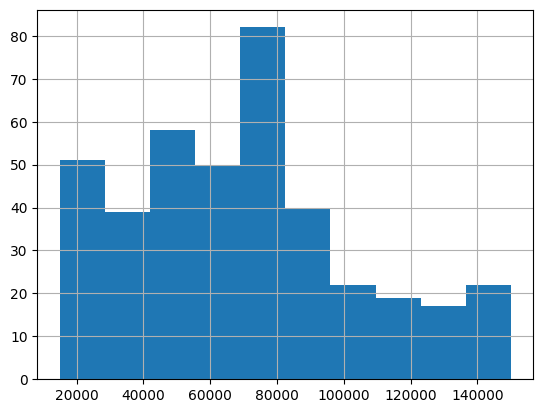

In [35]:
df['EstimatedSalary'].hist()

In [36]:
# let's check the unique options in the Gender-column in this data
df['Gender'].unique()

<StringArray>
['Male', 'Female']
Length: 2, dtype: str

### Handle categoricals, we only have a binary variable this time

In [37]:
# WITH BOOLEAN TEXT VALUES => LabelEncoder is the best option
# since we can convert all of the boolean variables all at once
# any text column with exactly two options is considered a boolean

# this just converts the value of column to 0 or 1
# factorize in pandas works too, but only one column at a time
from sklearn.preprocessing import LabelEncoder

# list of all boolean variables we want to convert
variables = ['Gender']

# initalize encoder and convert everything
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

In [38]:
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0


#### X/y and train/test split

In [39]:
# Box-Cox -transformation requires all data has to be positive
# NOT EVEN 0 IS ALLOWED

# uncomment this if you use PowerTransformer with Box-Cox -method
# df['Gender'] = df['Gender'] + 1

In [40]:
# a small trick => use everything else except, the target
X = df.drop("Purchased", axis=1)

# our target variable is y
y = df['Purchased']

In [41]:
# create train/test split with scikit-learn's helper function
# random_state is optional, you can lock down the randomness for same results everytime
# this is sometimes helpful when you want to minimize randomness in order to maximize optimizations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#### So far, everything has been as in previous examples, processing data, converting data formats etc.

#### In logistic regression, WE HAVE TO SCALE THE NUMERIC VALUES or otherwise the algorithm gets confused while predicting new values

In [42]:
# SINCE WE USE SCIKIT-LEARN'S PIPELINES
# WE DON'T HAVE TO MANUALLY SCALE OUR VALUES
# => THE PIPELINE TAKES CARE OF THAT

# # initialize the scaler and process X-values
# # IN MOST CASES you can experiment with MinMaxScaler 
# # and StandardScaler, ONLY USE ONE SCALER AT A TIME
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()

# # use fit_transform only once in the beginning
# # and use transform after that everywhere
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

#### Create the logistic regression model and fit the data

In [43]:
# we are now using a pipeline which AUTOMATICALLY
# scales our values with StandardScaler for us before using the LogisticRegression -model

# PowerTransformer(method='box-cox', standardize=True)

# to see Logistic Regression parameters that can be changed, see documentation:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# our pipeline: Scaler first, Regularization second, Model last
# regularization = optimization method that attaches to the learning method
# of our selected machine learning algorithm
# C -parameter is basically the "strength" of the regularization in the 
# inner parts of LogisticRegression. 
# Additional thought: the C-parameter does not necessarily 
# affect the result in this case, since we already have scaling + regularization before it
model = make_pipeline(StandardScaler(), 
                      PolynomialFeatures(degree=3, include_bias=True), 
                      LogisticRegression(solver="newton-cg", C=1.25))


# also tried with a fancy pipeline, but results got worse :(
# model = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True), 
#                       PolynomialFeatures(degree=2, include_bias=False), 
#                       LogisticRegression(solver="newton-cg", C=1.25))

model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('standardscaler', ...), ('polynomialfeatures', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"degree degree: int or tuple (min_degree, max_degree), default=2If a single int is given, it specifies the maximal degree of thepolynomial features. If a tuple `(min_degree, max_degree)` is passed,then `min_degree` is the minimum and `max_degree` is the maximumpolynomial degree of the generated features. Note that `min_degree=0`and `min_degree=1` are equivalent as outputting the degree zero term isdetermined by `include_bias`.",3
,"interaction_only interaction_only: bool, default=FalseIf `True`, only interaction features are produced: features that areproducts of at most `degree` *distinct* input features, i.e. terms withpower of 2 or higher of the same input feature are excluded:- included: `x[0]`, `x[1]`, `x[0] * x[1]`, etc.- excluded: `x[0] ** 2`, `x[0] ** 2 * x[1]`, etc.",False
,"include_bias include_bias: bool, default=TrueIf `True` (default), then include a bias column, the feature in whichall polynomial powers are zero (i.e. a column of ones - acts as anintercept term in a linear model).",True
,"order order: {'C', 'F'}, default='C'Order of output array in the dense case. `'F'` order is faster tocompute, but may slow down subsequent estimators... versionadded:: 0.21",'C'


#### Classification error metrics

In [44]:
# get the test predictions for metrics as usual
predictions = model.predict(X_test)

80-84% accuracy with original code, sometimes even up to 88% (probably a lucky fluke)

With some basic optimizations, 87-94% accuracy range

With locked down random seed, <b>a stable 96% accuracy every time </b>(see top part of the notebook for locking down the random seed)

In [45]:
# print the classification report based on true values and predictions
print(classification_report(y_test, predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        68
           1       0.97      0.91      0.94        32

    accuracy                           0.96       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.96      0.96      0.96       100


Model overall accuracy: 96.00%


[[67  1]
 [ 3 29]]


<Axes: >

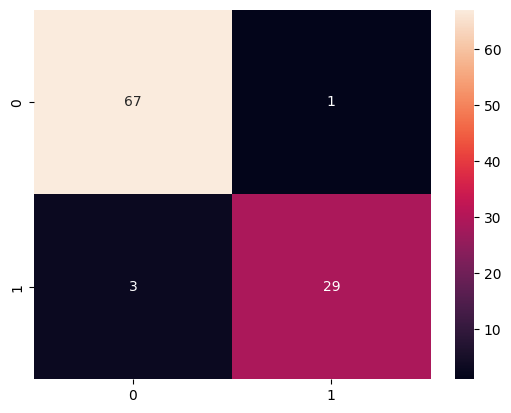

In [46]:
print(confusion_matrix(y_test, predictions))

# if you want a more graphical version of this, try:
# the fmt-parameter will change to decimal format from scientific format
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

In [47]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary logistic regression, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multinomial logistic regression , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# basically 0.5 means, there's still something to optimize
# if this falls under 0.5, random guessing works better than this model
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.9889705882352942

#### Using the model in practice

In [48]:
tester_row = {
    'Gender': 0, 
    'Age': 45, 
    'EstimatedSalary': 60000 
}

# create a pandas DataFrame and scale the values
tester_row = pd.DataFrame([tester_row])
# tester_row = sc.transform(tester_row)

print("All probabilities by category:")
print(model.predict_proba(tester_row))
print()

# change these based on your original data
labels = ["No", "Yes"]

print("Did this customer buy the service (Yes/No):")
result = labels[model.predict(tester_row)[0]]
print(result)
print("-------------------")

All probabilities by category:
[[0.68516777 0.31483223]]

Did this customer buy the service (Yes/No):
No
-------------------
